# Group 06 - ULg traffic characterization

## Utils

In [84]:
import matplotlib.pyplot as plt
from matplotlib import cm
from ipaddress import *
from os.path import commonprefix
import numpy as np

def plot_fig(x, y, title, xlabel, ylabel, scale='lin'):
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if scale == 'log':
        plt.loglog(x, y)
    else:
        plt.plot(x, y)


def plot_pie(values, labels, title):
    plt.figure()
    plt.title(title)

    cs = cm.Set1(np.arange(len(values)) / len(values))
    plt.pie(values, labels=labels, colors=cs, labeldistance=0.7)

    labels_with_values = []
    for i in range(0,len(values)):
        labels_with_values.append(str(labels[i]) + ' ({:.2f}%)'.format(values[i]*100))

    lgd = plt.legend(labels_with_values, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axis('equal')


## Imports & initialization

In [85]:
%matplotlib inline
from utils import *
from ipaddress import *
import pandas as pd


In [86]:
CHUNKSIZE = 10 ** 6

ibyts_pd = pd.Series() # Number of bytes
ipkts_pd = pd.Series() # Number of packets
durations_pd = pd.Series() # Durations

# Init with -1 to set the columns as integers
port_traffic_sender = pd.DataFrame({'sp': [-1], 'ibyt': [-1]}, index=[0]) 
port_traffic_receiver = pd.DataFrame({'dp': [-1], 'ibyt': [-1]}, index=[0])

traffic_by_ip = pd.DataFrame({'sa': [-1], 'ibyt': [-1]}, index=[0])

traffic_by_prefix_source = pd.DataFrame({'source_netw': [-1], 'ibyt': [-1], 'ipkt': [-1]}, index=[0])
traffic_by_prefix_dest = pd.DataFrame({'dest_netw': [-1], 'ibyt': [-1], 'ipkt': [-1]}, index=[0])

## Read CSV file and processing

In [87]:
i = 0
df_save = pd.DataFrame()
for df in pd.read_csv("netflow_2000000.csv", chunksize=CHUNKSIZE, iterator=True):
    i += 1
    print("Chunk number {}".format(i))
    df = df.dropna()
    
    # Gather number of bytes, packets and durations
    ibyts_pd = pd.concat([ibyts_pd, df[['ibyt']].ix[:,0]])
    ipkts_pd = pd.concat([ipkts_pd, df[['ipkt']].ix[:,0]])
    durations_pd = pd.concat([durations_pd, df[['td']].ix[:,0]])

    # Compute traffic by port
    port_traffic_sender = pd.concat([port_traffic_sender, df[['sp', 'ibyt']]])
    gb_sender = port_traffic_sender.groupby('sp')
    port_traffic_sender = gb_sender.sum().reset_index()

    port_traffic_receiver = pd.concat([port_traffic_receiver, df[['dp', 'ibyt']]])
    gb_receiver = port_traffic_receiver.groupby('dp')
    port_traffic_receiver = gb_receiver.sum().reset_index()

    # Compute traffic by IP
    # traffic_by_ip = pd.concat([traffic_by_ip, df[['sa', 'ibyt']]])
    # gb_ip = traffic_by_ip.groupby('sa')
    # traffic_by_ip = gb_ip.sum().reset_index()

    # Convert IP's into IPv4Address and IPv6Address (from ipaddress)
    df['source_netw'] = df['sa'].apply(lambda x: ip_address(x))
    df['dest_netw'] = df['da'].apply(lambda x: ip_address(x))
    
    # Apply mask /24 if IPv4 and /32 if IPv6
    df['source_netw'] = df['source_netw'].apply(lambda x: str(ip_interface(str(x) + '/24').network) if isinstance(x, IPv4Address) else str(ip_interface(str(x) + '/32').network))
    df['dest_netw'] = df['dest_netw'].apply(lambda x: str(ip_interface(str(x) + '/24').network) if isinstance(x, IPv4Address) else str(ip_interface(str(x) + '/32').network))

    traffic_by_prefix_source = pd.concat([traffic_by_prefix_source, df[['source_netw', 'ibyt', 'ipkt']]])
    gb_netw_source = traffic_by_prefix_source.groupby('source_netw')
    traffic_by_prefix_source = gb_netw_source.sum().reset_index()

    traffic_by_prefix_dest = pd.concat([traffic_by_prefix_dest, df[['dest_netw', 'ibyt', 'ipkt']]])
    gb_netw_source = traffic_by_prefix_dest.groupby('dest_netw')
    traffic_by_prefix_dest = gb_netw_source.sum().reset_index()

Chunk number 1
Chunk number 2


## Post-processing

In [88]:
port_traffic_sender = port_traffic_sender[port_traffic_sender.sp != -1]
port_traffic_sender['bytes_tot'] = port_traffic_sender['ibyt']

port_traffic_receiver = port_traffic_receiver[port_traffic_receiver.dp != -1]
port_traffic_receiver['bytes_tot'] = port_traffic_receiver['ibyt']

traffic_by_prefix_source = traffic_by_prefix_source[traffic_by_prefix_source.source_netw != -1]

traffic_by_prefix_dest = traffic_by_prefix_dest[traffic_by_prefix_dest.dest_netw != -1]


durations_pd = durations_pd.apply(lambda x: float(x))
ipkts_pd = ipkts_pd.apply(lambda x: int(x))
ibyts_pd = ibyts_pd.apply(lambda x: int(x))

## Questions

### Average packet size (in)

In [89]:
ipkt_size =ibyts_pd/ipkts_pd
ipkt_size = ipkt_size[~np.isnan(ipkt_size)]
if ipkt_size.size > 0:
    print("Average packet size: {0:.2f}\n".format(ipkt_size.mean()))

Average packet size: 212.30



### CCDF

In [90]:
sampling_step = 3 # Speed purpose (slowest but finest: 1)

#### Flow durations

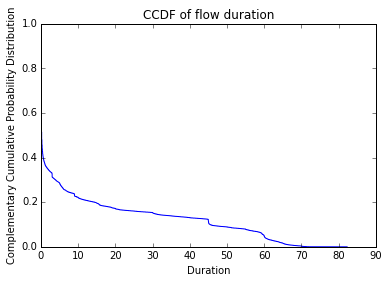

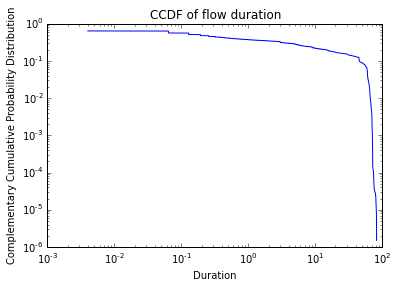

In [91]:
durations_pd_sorted = durations_pd.order()[::sampling_step]
yvals_durations = 1 - np.arange(len(durations_pd_sorted))/float(len(durations_pd_sorted))
plot_fig(title="CCDF of flow duration", x=durations_pd_sorted, y=yvals_durations, xlabel="Duration", ylabel="Complementary Cumulative Probability Distribution")
plot_fig(title="CCDF of flow duration", x=durations_pd_sorted, y=yvals_durations, xlabel="Duration", ylabel="Complementary Cumulative Probability Distribution", scale='log')

#### Flow size (number of bytes)

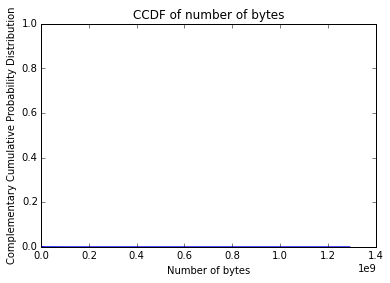

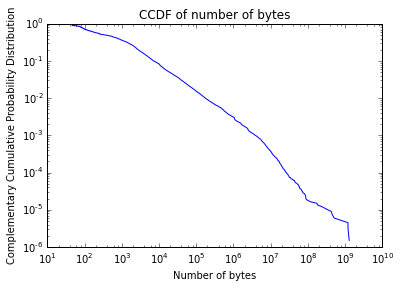

In [92]:
ibyts_pd_sorted = ibyts_pd.order()[::sampling_step]
yvals_ibyts = 1 - np.arange(len(ibyts_pd_sorted))/float(len(ibyts_pd_sorted))
plot_fig(title="CCDF of number of bytes", x=ibyts_pd_sorted, y=yvals_ibyts, xlabel="Number of bytes", ylabel="Complementary Cumulative Probability Distribution")
plot_fig(title="CCDF of number of bytes", x=ibyts_pd_sorted, y=yvals_ibyts, xlabel="Number of bytes", ylabel="Complementary Cumulative Probability Distribution", scale='log')


#### Flow size (number of packets)

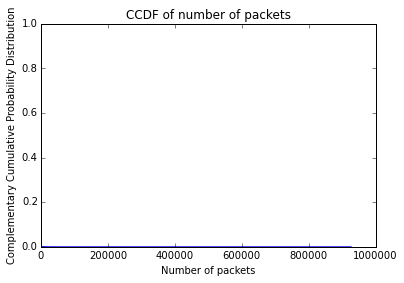

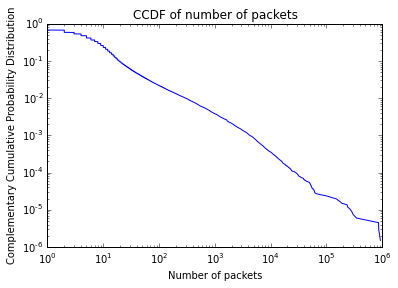

In [93]:
ipkts_pd_sorted = ipkts_pd.order()[::sampling_step]
yvals_ipkts = 1 - np.arange(len(ipkts_pd_sorted))/float(len(ipkts_pd_sorted))
plot_fig(title="CCDF of number of packets", x=ipkts_pd_sorted, y=yvals_ipkts, xlabel="Number of packets", ylabel="Complementary Cumulative Probability Distribution")
plot_fig(title="CCDF of number of packets", x=ipkts_pd_sorted, y=yvals_ipkts, xlabel="Number of packets", ylabel="Complementary Cumulative Probability Distribution", scale='log')


### Traffic by ports

#### Computations

In [94]:
sum_bytes_sender = port_traffic_sender['bytes_tot'].sum()
sum_bytes_receiver = port_traffic_receiver['bytes_tot'].sum()

port_traffic_sender['bytes_tot_per'] = port_traffic_sender['bytes_tot'] / sum_bytes_sender
port_traffic_receiver['bytes_tot_per'] = port_traffic_receiver['bytes_tot'] / sum_bytes_receiver

top_10_sender = port_traffic_sender.sort(['bytes_tot_per'], ascending=[False])[0:10]
top_10_receiver = port_traffic_receiver.sort(['bytes_tot_per'], ascending=[False])[0:10]
not_top_10_sender = port_traffic_sender.sort(['bytes_tot_per'], ascending=[False])[10:]
not_top_10_receiver = port_traffic_receiver.sort(['bytes_tot_per'], ascending=[False])[10:]

#### Sender

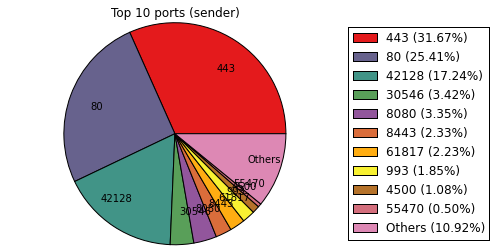

In [95]:
port_sender_list = [int(label) for label in top_10_sender['sp'].values.tolist()]
port_sender_list.append("Others")
labels_sender = tuple(port_sender_list)
values_sender = top_10_sender['bytes_tot_per'].values.tolist()
values_sender.append(not_top_10_sender['bytes_tot_per'].sum())

plot_pie(values_sender, labels_sender, "Top 10 ports (sender)")

#### Receiver

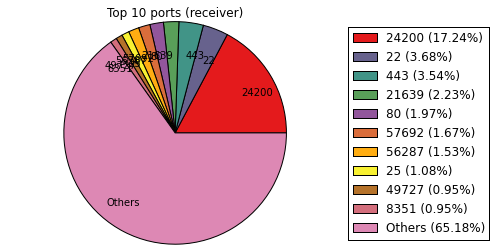

In [96]:
port_receiver_list = [int(label) for label in top_10_receiver['dp'].values.tolist()]
port_receiver_list.append("Others")
labels_receiver = tuple(port_receiver_list)
values_receiver = top_10_receiver['bytes_tot_per'].values.tolist()
values_receiver.append(not_top_10_receiver['bytes_tot_per'].sum())

plot_pie(values_receiver, labels_receiver, "Top 10 ports (receiver)")

### Traffic by prefixes

#### Computations

In [97]:
traffic_by_prefix_source_ordered = traffic_by_prefix_source.sort(['ibyt'], ascending=[False])
traffic_by_prefix_source_ordered_tot = traffic_by_prefix_source_ordered['ibyt'].sum()
traffic_by_prefix_source_len = len(traffic_by_prefix_source.index)

#### Top 0.1%

In [98]:
n_01 = round(0.001 * traffic_by_prefix_source_len)
traffic_by_prefix_source_n01 = traffic_by_prefix_source_ordered[:n_01]
part_total_traffic_01 = traffic_by_prefix_source_n01['ibyt'].sum() / traffic_by_prefix_source_ordered_tot
print("Percentage of the traffic from the top 0.1% prefixes: {:.5f}%".format(part_total_traffic_01*100))

Percentage of the traffic from the top 0.1% prefixes: 67.66709%


#### Top 1%

In [99]:
n_1 = round(0.01 * traffic_by_prefix_source_len)
traffic_by_prefix_source_n1 = traffic_by_prefix_source_ordered[:n_1]
part_total_traffic_1 = traffic_by_prefix_source_n1['ibyt'].sum() / traffic_by_prefix_source_ordered_tot
print("Percentage of the traffic from the top 1% prefixes: {:.5f}%".format(part_total_traffic_1*100))

Percentage of the traffic from the top 1% prefixes: 92.71856%


#### Top 10%

In [100]:
n_10 = round(0.1 * traffic_by_prefix_source_len)
traffic_by_prefix_source_n10 = traffic_by_prefix_source_ordered[:n_10]
part_total_traffic_10 = traffic_by_prefix_source_n10['ibyt'].sum() / traffic_by_prefix_source_ordered_tot
print("Percentage of the traffic from the top 10% prefixes: {:.5f}%".format(part_total_traffic_10*100))

Percentage of the traffic from the top 10% prefixes: 99.41588%


### 92.106.195.0/24 address block

#### Computations

In [101]:
traffic_by_prefix_source = traffic_by_prefix_source[traffic_by_prefix_source['source_netw'] != -1]
traffic_by_prefix_dest = traffic_by_prefix_dest[traffic_by_prefix_dest['dest_netw'] != -1]

total_traffic_source_pkts = traffic_by_prefix_source['ipkt'].sum()
total_traffic_source_byts = traffic_by_prefix_source['ibyt'].sum()
total_traffic_dest_pkts = traffic_by_prefix_dest['ipkt'].sum()
total_traffic_dest_byts = traffic_by_prefix_dest['ibyt'].sum()

block_source = traffic_by_prefix_source[traffic_by_prefix_source['source_netw'] == '92.106.195.0/24']
block_dest = traffic_by_prefix_dest[traffic_by_prefix_dest['dest_netw'] == '92.106.195.0/24']

#### Results

In [102]:
if len(block_source.index) > 0:
    print('Fraction of traffic sent by 92.106.195.0/24 (in pkts): {:.3%}'.format(traffic_by_prefix_source[traffic_by_prefix_source['source_netw'] == '92.106.195.0/24']['ipkt'].iloc[0]/total_traffic_source_pkts))
    print('Fraction of traffic sent by 92.106.195.0/24 (in bytes): {:.3%}'.format(traffic_by_prefix_source[traffic_by_prefix_source['source_netw'] == '92.106.195.0/24']['ibyt'].iloc[0]/total_traffic_source_byts))

if len(block_dest.index) > 0:
    print('Fraction of traffic sent to 92.106.195.0/24 (in pkts): {:.3%}'.format(traffic_by_prefix_dest[traffic_by_prefix_dest['dest_netw'] == '92.106.195.0/24']['ipkt'].iloc[0]/total_traffic_dest_pkts))
    print('Fraction of traffic sent to 92.106.195.0/24 (in bytes): {:.3%}'.format(traffic_by_prefix_dest[traffic_by_prefix_dest['dest_netw'] == '92.106.195.0/24']['ibyt'].iloc[0]/total_traffic_dest_byts))


Fraction of traffic sent by 92.106.195.0/24 (in pkts): 1.372%
Fraction of traffic sent by 92.106.195.0/24 (in bytes): 1.618%
Fraction of traffic sent to 92.106.195.0/24 (in pkts): 1.053%
Fraction of traffic sent to 92.106.195.0/24 (in bytes): 0.667%
